# Non-negative Matrix Factorization
## A comparison against supervised learning

This kernel is a demonstration on how to use Non-negative Matrix Factorization for unsupervised machine learning in the context of Topic Extraction.
Also there is a comparison with supervised machine learning in the form of Long Short Term Memory with GloVe word embeddings which is proven to work well with sequence data, such as text analysis, as well as a dense model, using the same input format as the unsupervised model.

First we need to import the libraries that are required.

In [3]:
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
import csv
import re
import itertools
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt
from prettytable import PrettyTable

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

The cell below define the two functions that translate text into GloVe vectors.
The vectors are n-dimensional representations for the *meaning* of a particular word based on an analysis of a huge corpus of text. The co-occurence of words is what is used to derive the vector representations.

More information here: [https://nlp.stanford.edu/projects/glove/](http://) .

Regular expressions are used to filter out any special characters and all words are translated to lowercase characters.

In [4]:
def process_review(review):
    review_vectors = np.zeros((MAX_REVIEW_LENGTH, VECTORS_PER_WORD))

    i = 0
    for word in re.sub(r'\W+', ' ', review['Text']).split(' '):
        try:
            review_vectors[i, :] = df_glove.loc[word]
        except KeyError:
            #print(word + ' not found')
            continue
                
        i += 1
            
        if i == MAX_REVIEW_LENGTH:
            return review_vectors
        
    return review_vectors

def vectorize_reviews(dataframe):
    # First create a blank matrix for our word vectors
#    vectorized_data = np.zeros((len(dataframe.index), MAX_REVIEW_LENGTH, VECTORS_PER_WORD))

    # Now loop thorugh the words and add the corresponding vectors to the matrix
    vectorized_data = dataframe.apply(process_review, args=(), axis=1,)
    
    print(vectorized_data)
    print(vectorized_data.shape)

    return vectorized_data

For the matrix factorization I found that the GloVe vectors worked poorly so instead I use a simple "bag of word" approach where a dictionary of words represented in the training material is built and used for a simple word count for each text.

For example if the traning material is:

"John likes to eat fish",

"John has a bicycle",

"Some fish eat fish"

Would result in this word dictionary:
["john", "likes", "to", "eat", "fish", "has", "a", "bicycle", "some"] .

In [5]:
def build_word_list(dataframe, max_words):
    word_counts = {}
    all_words = []
    
    for index, row in dataframe.iterrows():
        for word in re.sub(r'\W+', ' ', row['Text']).lower().split(' '):
            try:
                word_counts[word] += 1
            except KeyError:
                word_counts[word] = 1

    for word in sorted(word_counts.items(), key=lambda x:x[1], reverse=True)[:max_words]:
        all_words += [word[0]]

    return all_words

Now we want to convert the training texts into bags of words based on the dictionary built above.

The example mentioned above we get
[[1, 1, 1, 1, 1, 0, 0, 0, 0],[1, 0, 0, 0, 0, 1, 1, 1, 0], [0, 0, 0, 1, 2, 0, 0, 0, 1]] .

In [6]:
def convert_from_bag_of_words(dataframe, max_words):
    vectorized_data = np.zeros((len(dataframe.index), max_words))
    words_subset = all_words[:max_words]
    
    i = 0
    for index, row in dataframe.iterrows():
        new_entry = np.zeros(max_words)
        words = re.sub(r'\W+', ' ', row['Text']).lower().split(' ')
        for word in words:
            try:
                new_entry[words_subset.index(word)] += 1
            except ValueError:
                #print('Word not found: ' + word)
                continue
            
        vectorized_data[i] = new_entry
        i += 1
                
    return vectorized_data

As is normal practice with unsupervised learning we know we have the correct number of groups in the result when compared against the ground truth but we do not know how the groups are connected. there are different ways to determine which group belongs to which class but the easiest is just to try all combinations and pick the combination that results in the best accuracy which is what we do below.

In [7]:
def define_labels(dataframe, predictions):
    permutations = list(itertools.permutations([0, 1, 2, 3, 4]))
    best_label_combination = []
    best_count = 0
    
    for permutation in permutations:
        df_predictions = pd.DataFrame()
        df_predictions['y_true'] = dataframe['Category']
        df_predictions['y_pred'] = predictions

        for number in range(0, 5):
            df_predictions['y_pred'] = df_predictions['y_pred'].replace(number, LABELS[permutation[number]])
        
        count = len(df_predictions.loc[df_predictions['y_true'] == df_predictions['y_pred']].index)
        if count > best_count:
            best_count = count
            best_label_combination = permutation
            accuracy = accuracy_score(df_predictions['y_true'], df_predictions['y_pred'])
            
    return best_count, best_label_combination, accuracy

The cell below defines the function that translate the test dataset predictions to category names.

In [8]:
def translate_to_category(predictions, best_label_combination):
    label_predictions = []
    
    for prediction in predictions:
        label_predictions += [LABELS[best_label_combination[prediction]]]

    return label_predictions

Define a densely connected neural network model as a benchmark measurement for supervised learning in the form of a simple neural network.

In [9]:
def build_supervised_dense_model():
    dropout_level = 0.25
    
    model_input = tf.keras.layers.Input(shape=MAX_WORDS)
    model_dropout1 = tf.keras.layers.Dropout(dropout_level)(model_input)
    model_dense1 = tf.keras.layers.Dense(100, activation='relu')(model_dropout1)
    model_dropout2 = tf.keras.layers.Dropout(dropout_level)(model_dense1)
    model_output = tf.keras.layers.Dense(len(LABELS), activation='softmax')(model_dropout2)
    
    model = tf.keras.Model(inputs=model_input, outputs=model_output)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

Define the LSTM model to get a comparison for a proven supervised approach against the unsupervised model.

In [10]:
def build_supervised_lstm_model():
    dropout_level = 0.15
    
    model_input = tf.keras.layers.Input(shape=[MAX_REVIEW_LENGTH, VECTORS_PER_WORD])
    model_lstm = tf.keras.layers.LSTM(200)(model_input)
    model_dropout1 = tf.keras.layers.Dropout(dropout_level)(model_lstm)
    model_dense1 = tf.keras.layers.Dense(50, activation='relu')(model_dropout1)
    model_dropout2 = tf.keras.layers.Dropout(dropout_level)(model_dense1)
    model_output = tf.keras.layers.Dense(len(LABELS), activation='softmax')(model_dropout2)
    
    model = tf.keras.Model(inputs=model_input, outputs=model_output)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

Import the train and test datasets into Pandas dataframes as well as the GloVe vectors.

In [11]:
df_train = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
df_test = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')
df_glove = pd.read_csv('/kaggle/input/glove6b/glove.6B.50d.txt', sep=' ', index_col=0, header = None, quoting=csv.QUOTE_NONE, encoding='utf-8')

Define a few global constants;

MAX_REVIEW_LENGTH: Not used in the matrix factorization but used for the supervised learning comparison (translation of texts to word embeddings where this decides the maximum number of words used from each text). Here specify to include up to 200 words from each article. We need to strike a balance as more words would yield a more accurate prediction but it will take significantly longer to process the text.

VECTORS_PER_WORD: Here we use the 50-digit GloVe representations for each word (again only used in the supervised learning comparison).

MAX_WORDS: This specifies how many unique words to include in the dictionary for the matrix factorization. Since this directly translates into the features in the model training this has to strike a balance between accuracy and speed of training (particularly considering the fact that we want to try many different hyper parameters). We have more than 600,000 unique words in the training texts so including all would be almost impossibly slow. Also the fact that including very rare words could lead to overfitting should be taken into account. Here we define to use the 5000 most common words.

LABELS: These are the possible categories.

In [15]:
MAX_REVIEW_LENGTH = 200
VECTORS_PER_WORD = 50
MAX_WORDS = 5000

LABELS = ['business', 'tech', 'politics', 'sport', 'entertainment']

Before training and comparing any models we need to take a look at the data.
First number of samples in the training dataset and the names of the columns.

In [16]:
print('Number of samples in training data: ' + str(len(df_train.index)))
print('Fields: ' + str(df_train.columns))

Number of samples in training data: 1490
Fields: Index(['ArticleId', 'Text', 'Category'], dtype='object')


Let us have a closer look at the length of the texts in the training dataset. As we can see sports and entertainment articles tend to be shorter, many around 200-300 words, whereas politics tend to be long articles, with a few even reaching several thousand words.

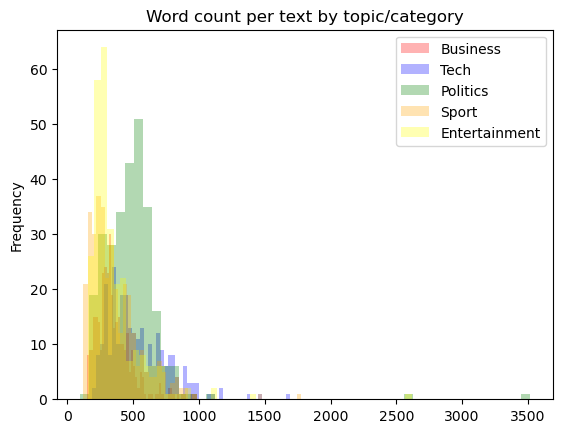

In [17]:
def count_length(line):
    return len(line['split'])

df_length_texts_business = pd.DataFrame()
df_length_texts_business['split'] = df_train[df_train['Category'] == 'business']['Text'].str.split(' ')
df_length_texts_business['word_count'] = df_length_texts_business.apply(lambda x: count_length(x),axis=1)

df_length_texts_tech = pd.DataFrame()
df_length_texts_tech['split'] = df_train[df_train['Category'] == 'tech']['Text'].str.split(' ')
df_length_texts_tech['word_count'] = df_length_texts_tech.apply(lambda x: count_length(x),axis=1)

df_length_texts_politics = pd.DataFrame()
df_length_texts_politics['split'] = df_train[df_train['Category'] == 'politics']['Text'].str.split(' ')
df_length_texts_politics['word_count'] = df_length_texts_politics.apply(lambda x: count_length(x),axis=1)

df_length_texts_sport = pd.DataFrame()
df_length_texts_sport['split'] = df_train[df_train['Category'] == 'sport']['Text'].str.split(' ')
df_length_texts_sport['word_count'] = df_length_texts_sport.apply(lambda x: count_length(x),axis=1)

df_length_texts_entertainment = pd.DataFrame()
df_length_texts_entertainment['split'] = df_train[df_train['Category'] == 'entertainment']['Text'].str.split(' ')
df_length_texts_entertainment['word_count'] = df_length_texts_entertainment.apply(lambda x: count_length(x),axis=1)

fig, ax = plt.subplots()

ax.hist(df_length_texts_business['word_count'], bins=50, alpha=0.3, color='red', label='Business')
ax.hist(df_length_texts_tech['word_count'], bins=50, alpha=0.3,color='blue', label='Tech')
ax.hist(df_length_texts_politics['word_count'], bins=50, alpha=0.3, color='green', label='Politics')
ax.hist(df_length_texts_sport['word_count'], bins=50, alpha=0.3,color='orange', label='Sport')
ax.hist(df_length_texts_entertainment['word_count'], bins=50, alpha=0.3,color='yellow', label='Entertainment')

ax.set_ylabel('Frequency')
ax.set_title(label='Word count per text by topic/category')
ax.legend(title='Words in text')

plt.legend(loc='upper right')

plt.show()

Build the list of the MAX_WORDS most popular words in all the training texts.

In [18]:
all_words = build_word_list(df_train, MAX_WORDS)

Let's see the list of the 25 most popular words.

In [14]:
myTable = PrettyTable()
 
# Add rows
myTable.add_row([all_words[0], all_words[1], all_words[2], all_words[3], all_words[4]])
myTable.add_row([all_words[5], all_words[6], all_words[7], all_words[8], all_words[9]])
myTable.add_row([all_words[10], all_words[11], all_words[12], all_words[13], all_words[14]])
myTable.add_row([all_words[15], all_words[16], all_words[17], all_words[18], all_words[19]])
myTable.add_row([all_words[20], all_words[21], all_words[22], all_words[23], all_words[24]])
 
print(myTable)

+---------+---------+---------+---------+---------+
| Field 1 | Field 2 | Field 3 | Field 4 | Field 5 |
+---------+---------+---------+---------+---------+
|   the   |    to   |    of   |   and   |    a    |
|    in   |    s    |   for   |    is   |   that  |
|    it   |    on   |   said  |   was   |    he   |
|    be   |   with  |   has   |    as   |   have  |
|    at   |    by   |   will  |   but   |   are   |
+---------+---------+---------+---------+---------+


Convert the training texts to input for the matrix factorization.

In [20]:
X_bag_of_words = convert_from_bag_of_words(df_train, MAX_WORDS)

In the following cell we try different combinations of hyperparameters in search of the combination that will yield the best accuracy. It should be noted that it is assumed that this is the best model but that may not be the case (overfitting will yield a model that has a high accuracy on the training dataset but may perform very poorly on the test dataset.

It is a bit of a lazy implementation for searching for optimal hyperparameters. It is probably worth looking into sklearn.model_selection.GridSearchCV or similar.

On initial trials I've ruled out solver: 'cd' is that seems to perform poorly on this data.

In [21]:
#For parameter search
beta_losses = ['frobenius', 'kullback-leibler']
inits = ['random', 'nndsvda', 'nndsvdar']
alpha_ws = l1_ratios = [0.0, 0.0005, 0.001, 0.0015, 0.002, 0.0025]

## Best parameter combination - for shortcutting the time consuming search for parameters
#beta_losses = ['kullback-leibler']
#inits = ['nndsvda']
#alpha_ws = [0.001]
#l1_ratios = [0.0]

matches = None
best_label_combination = None
accuracy = 0
predictions = None
model = None

print('Searching for best hyperparameter combination. This will take a while!')

for beta_loss in beta_losses:
    for init in inits:
        for alpha_w in alpha_ws:
            for l1_ratio in l1_ratios:
                # Define the model
                model_candidate = NMF(n_components=5, 
                                    init=init, 
                                    solver = 'mu',
                                    beta_loss = beta_loss,
                                    alpha_W = alpha_w,
                                    l1_ratio = l1_ratio,
                                    random_state = 101)

                # Fit the training data on the model and transform to result
                try:
                    W = model_candidate.fit_transform(X_bag_of_words)
                except ValueError:
                    print('Doesn`t work! [' + beta_loss + '], init: [' + init + '], alpha_W: [' + str(alpha_w) + '], l1_ratio: ['\
                            + str(l1_ratio) + ']')
                    continue

                # Find the highest scoring component for each sample
                predictions_temp = np.argmax(W, axis=1)
                # Not strictly nessecary but a dataframe is just easier for replacing processing
                df = pd.DataFrame()
                df['Predictions'] = predictions_temp
                # Find the best fitting combination of classes as well as the accuracy for that combination
                matches_temp, best_label_combination_temp, accuracy_temp = define_labels(df_train, predictions_temp)
                    
                if accuracy_temp > accuracy:
                    print('Found a better hyperparameter combination with solver: [' \
                            + beta_loss + '], init: [' + init + '], alpha_W: [' + str(alpha_w) + '], l1_ratio: ['\
                            + str(l1_ratio) + ']')
                    print('Candidate accuracy: ' + str(accuracy_temp))
                    matches = matches_temp
                    best_label_combination = best_label_combination_temp
                    accuracy = accuracy_temp
                    predictions = predictions_temp
                    model = model_candidate

Searching for best hyperparameter combination. This will take a while!
Found a better hyperparameter combination with solver: [frobenius], init: [random], alpha_W: [0.0], l1_ratio: [0.0]
Candidate accuracy: 0.4993288590604027
Found a better hyperparameter combination with solver: [kullback-leibler], init: [random], alpha_W: [0.0], l1_ratio: [0.0]
Candidate accuracy: 0.8261744966442953
Found a better hyperparameter combination with solver: [kullback-leibler], init: [random], alpha_W: [0.001], l1_ratio: [0.0]
Candidate accuracy: 0.8295302013422818
Found a better hyperparameter combination with solver: [kullback-leibler], init: [nndsvda], alpha_W: [0.0], l1_ratio: [0.0]
Candidate accuracy: 0.9369127516778524
Found a better hyperparameter combination with solver: [kullback-leibler], init: [nndsvda], alpha_W: [0.0005], l1_ratio: [0.0]
Candidate accuracy: 0.9402684563758389
Found a better hyperparameter combination with solver: [kullback-leibler], init: [nndsvda], alpha_W: [0.001], l1_ratio:

Print final accuracy on the training dataset using the unsupervised Non-negative Matrix Factorization approach.

In [17]:
print('Done determining best hyperparameters. Accuracy achieved: ' + str(accuracy))

Done determining best hyperparameters. Accuracy achieved: 0.9422818791946309


Convert the test dataset texts to MAX_WORDS "bags of words".

In [18]:
X_test = convert_from_bag_of_words(df_test, MAX_WORDS)

Predict results from the test data.

In [19]:
X_test = convert_from_bag_of_words(df_test, MAX_WORDS)
W = model.transform(X_test)
predictions = np.argmax(W, axis=1)
categories = translate_to_category(predictions, best_label_combination)

Create the submission file for the unsupervised approach.

In [20]:
#Build a submission file. The model scores > 0.95 with the unknown test data as late submission.
df_submission = pd.DataFrame()
df_submission['ArticleId'] = df_test['ArticleId']
df_submission['Category'] = categories
df_submission.to_csv('submission.csv', index=False)

Convert the training texts to GloVe vector representations of shape 200x50 used as input in the LSTM model.

In [24]:
print('Calculating GloVe vectors for the training texts. This will run for some time!')
X_glove = vectorize_reviews(df_train)
X_new = np.zeros((len(df_train.index), X_glove[0].shape[0], X_glove[0].shape[1]))
for i in range(0, len(df_train.index)):
    X_new[i] = X_glove[i]

Calculating GloVe vectors for the training texts. This will run for some time!
0       [[1.5421, -0.74284, 1.0068, 1.8362, -0.35369, ...
1       [[0.29942, -0.09967, -0.0012405, -1.3147, 0.29...
2       [[-0.2228, 0.042332, -0.42852, 0.045287, -0.57...
3       [[-0.04451, 0.63078, -1.0844, -0.23987, -0.076...
4       [[1.1183, -0.71865, 1.0148, 1.1814, 0.25469, 0...
                              ...                        
1485    [[-0.323, 0.77562, 0.31996, 0.24053, 0.21769, ...
1486    [[-1.2636, 0.12616, 0.5781, 0.23193, -0.51517,...
1487    [[-0.26241, -1.1103, 0.50271, -0.43052, 0.3746...
1488    [[0.52042, -0.8314, 0.49961, 1.2893, 0.1151, 0...
1489    [[0.77514, -0.87855, 0.073737, -0.54224, -0.11...
Length: 1490, dtype: object
(1490,)


Translate the labels to one-hot encoded values.

In [25]:
y_old = df_train['Category'].to_list()
y_new = np.zeros((len(y_old), len(LABELS)))

i = 0
for i in range(0, len(y_old)):
    y_new[i, LABELS.index(y_old[i])] = 1

Build the first supervised model to compare with - a densely connected neural network also known as a perceptron network.

In [26]:
model = build_supervised_dense_model()
model.summary()
model.fit(X_bag_of_words, y_new, epochs = 20)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5000)]            0         
                                                                 
 dropout (Dropout)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 100)               500100    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 500,605
Trainable params: 500,605
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
47/47 [==============================] - 1s 

Get the predictions on the training dataset and convert the numeric values to category classes.

In [27]:
predictions_supervised = np.argmax(model.predict(X_bag_of_words), axis=1)
categories = translate_to_category(predictions_supervised, [0, 1, 2, 3, 4])

47/47 [==============================] - 0s 4ms/step


Calculate and print accuracy on the training data set. Note that an overfitted model may perform excellently here but miserably with the test dataset.

In [28]:
accuracy_dense = accuracy_score(df_train['Category'], categories)
print('Supervised training (dense NN) accuracy achieved on training set: ' + str(accuracy_dense))

Supervised training (dense NN) accuracy achieved on training set: 1.0


Get the predictions of the test dataset. This will be the real test of how the model performs

In [29]:
predictions_supervised = np.argmax(model.predict(X_test), axis=1)
categories = translate_to_category(predictions_supervised, [0, 1, 2, 3, 4])

23/23 [==============================] - 0s 3ms/step


Build a submission file from the test dataset for a supervised model comparison using a densely connected neural network (also known as a perceptron network).

This file has been scored as "late submission" as 0.974.

In [30]:
df_submission = pd.DataFrame()
df_submission['ArticleId'] = df_test['ArticleId']
df_submission['Category'] = categories
df_submission.to_csv('supervised_dense_submission.csv', index=False)

For the final comparison with a supervised approach we will train and LSTM neural network. As input we are using GloVe word vectorizations so that each word in the text is represented by 50 digits.

In [42]:
model = build_supervised_lstm_model()
model.summary()
model.fit(X_new, y_new, epochs = 50)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200, 50)]         0         
                                                                 
 lstm_3 (LSTM)               (None, 200)               200800    
                                                                 
 dropout_8 (Dropout)         (None, 200)               0         
                                                                 
 dense_8 (Dense)             (None, 50)                10050     
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 5)                 255       
                                                                 
Total params: 211,105
Trainable params: 211,105
Non-trainab

Convert LSTM training redictions to categories for comparison against the ground truth.

In [43]:
predictions_supervised_lstm = np.argmax(model.predict(X_new), axis=1)
categories = translate_to_category(predictions_supervised_lstm, [0, 1, 2, 3, 4])

47/47 [==============================] - 7s 142ms/step


Predict final LSTM accuracy on the known training dataset.

In [44]:
accuracy_lstm = accuracy_score(df_train['Category'], categories)
print('Supervised training (LSTM) accuracy achieved on training set: ' + str(accuracy_lstm))

Supervised training (LSTM) accuracy achieved on training set: 0.946979865771812


Convert the test dataset to GloVe word embeddings.

In [ ]:
X = vectorize_reviews(df_test)
X_new = np.zeros((len(df_test.index), X[0].shape[0], X[0].shape[1]))
for i in range(0, len(df_test.index)):
    X_new[i] = X[i]

Predict and convert LSTM test dataset predictions to categories.

In [ ]:
predictions_supervised = np.argmax(model.predict(X_new), axis=1)
categories = translate_to_category(predictions_supervised, [0, 1, 2, 3, 4])

Finally build a submissions file from the test dataset using the LSTM model. This file scores about 0.94 as a late submission.

In [ ]:
df_submission = pd.DataFrame()
df_submission['ArticleId'] = df_test['ArticleId']
df_submission['Category'] = categories
df_submission.to_csv('supervised_lstm_submission.csv', index=False)

As we have seen the models are very comparable in accuracy in this setup, but I have not done an exhaustive search for best model design for the two supervised models so there is a lot of room for improvement there. 
I have not done any stemming or advanced word processing either, only basic processing to remove special characters.

By further pre-processing of the texts and carefully balancing the size of the input data used to train the models (it is a balance between too little data that might result in underfitting models but where finding the optimal hyperparameters would be easier and faster and too much data fed into the models (number of words from each text or in the word dictionary) which might result in overfitting and with a slower process impeding the search for optimal hyperparameters.

As we don't have the labels for the test dataset (obviously) I've submitted each submission file and hardcoded the result below.

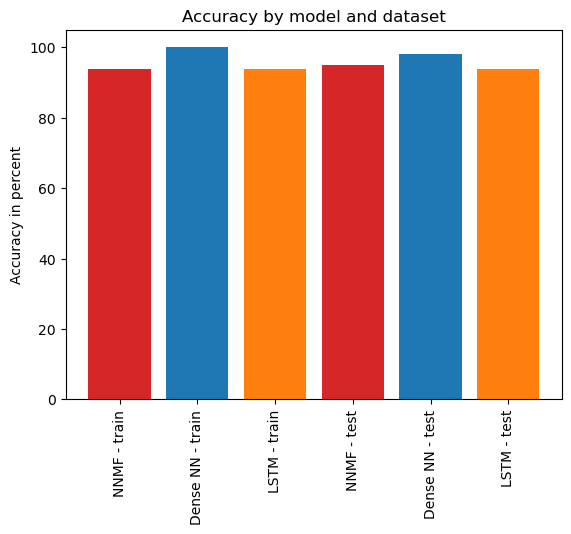

In [13]:
accuracy_train = [accuracy, accuracy_dense, accuracy_lstm]

fig, ax = plt.subplots()

accuracy_labels = ['NNMF - train', 'Dense NN - train', 'LSTM - train', 'NNMF - test', 'Dense NN - test', 'LSTM - test']
accuracies = [int(accuracy * 100), int(accuracy_dense * 100), int(accuracy_lstm * 100), 95, 98, 94]
bar_labels = ['red', 'blue', 'orange', 'red', 'blue', 'orange']
bar_colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:red', 'tab:blue', 'tab:orange']

ax.bar(accuracy_labels, accuracies, color=bar_colors)

ax.set_ylabel('Accuracy in percent')
ax.set_title(label='Accuracy by model and dataset')

plt.xticks(rotation=90)

plt.show()